<a href="https://www.kaggle.com/code/gpreda/rag-using-llama-2-langchain-and-chromadb?scriptVersionId=145678908" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F769452%2Fb18d0513200d426e556b2b7b7c825981%2FRAG.png?generation=1695504022336680&alt=media"></img>

## Objective

Use Llama 2.0, Langchain and ChromaDB to create a Retrieval Augmented Generation (RAG) system. This will allow us to ask questions about our documents (that were not included in the training data), without fine-tunning the Large Language Model (LLM).
When using RAG, if you are given a question, you first do a retrieval step to fetch any relevant documents from a special database, a vector database where these documents were indexed. 

## Definitions

* LLM - Large Language Model  
* Llama 2.0 - LLM from Meta 
* Langchain - a framework designed to simplify the creation of applications using LLMs
* Vector database - a database that organizes data through high-dimmensional vectors  
* ChromaDB - vector database  
* RAG - Retrieval Augmented Generation (see below more details about RAGs)

## Model details

* **Model**: Llama 2  
* **Variation**: 7b-chat-hf  (7b: 7B dimm. hf: HuggingFace build)
* **Version**: V1  
* **Framework**: PyTorch  

LlaMA 2 model is pretrained and fine-tuned with 2 Trillion tokens and 7 to 70 Billion parameters which makes it one of the powerful open source models. It is a highly improvement over LlaMA 1 model.


## What is a Retrieval Augmented Generation (RAG) system?

Large Language Models (LLMs) has proven their ability to understand context and provide accurate answers to various NLP tasks, including summarization, Q&A, when prompted. While being able to provide very good answers to questions about information that they were trained with, they tend to hallucinate when the topic is about information that they do "not know", i.e. was not included in their training data. Retrieval Augmented Generation combines external resources with LLMs. The main two components of a RAG are therefore a retriever and a generator.  
 
The retriever part can be described as a system that is able to encode our data so that can be easily retrieved the relevant parts of it upon queriying it. The encoding is done using text embeddings, i.e. a model trained to create a vector representation of the information. The best option for implementing a retriever is a vector database. As vector database, there are multiple options, both open source or commercial products. Few examples are ChromaDB, Mevius, FAISS, Pinecone, Weaviate. Our option in this Notebook will be a local instance of ChromaDB (persistent).

For the generator part, the obvious option is a LLM. In this Notebook we will use a quantized LLaMA v2 model, from the Kaggle Models collection.  

The orchestration of the retriever and generator will be done using Langchain. A specialized function from Langchain allows us to create the receiver-generator in one line of code.
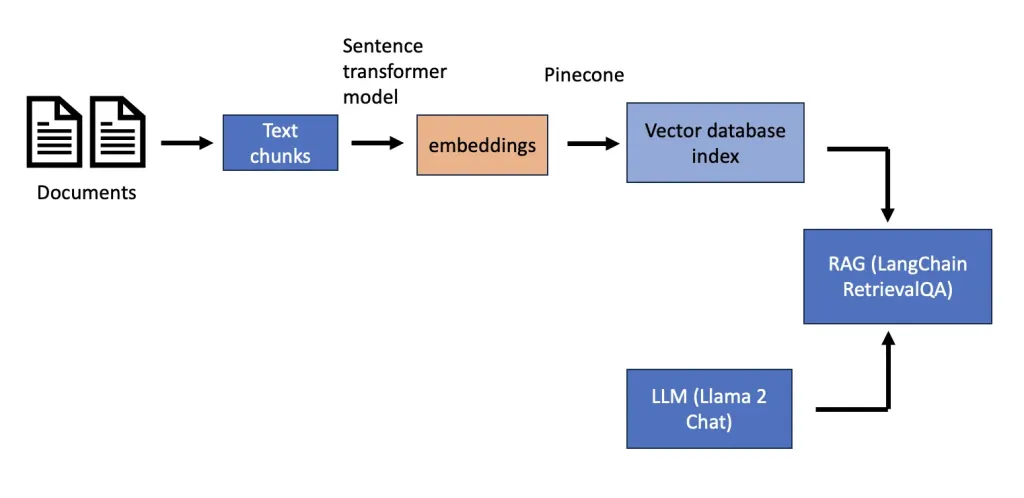

# Installations, imports, utils

In [1]:
!pip install transformers accelerate einops langchain xformers bitsandbytes chromadb sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.6/211.6 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.8/437.8 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.4 MB/s 

In [2]:
from torch import cuda, bfloat16
import torch
import transformers
from transformers import AutoTokenizer
from time import time
import chromadb
from chromadb.config import Settings
from langchain.llms import HuggingFacePipeline
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.vectorstores import Chroma


# Initialize model, tokenizer, query pipeline

Define the model, the device, and the `bitsandbytes` configuration.

In [3]:
model_id = '/kaggle/input/llama-2/pytorch/7b-chat-hf/1'

device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'

# set quantization configuration to load large model with less GPU memory
# this requires the `bitsandbytes` library
bnb_config = transformers.BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=bfloat16
)

Prepare the model and the tokenizer.

In [4]:
time_1 = time()
model_config = transformers.AutoConfig.from_pretrained(
    model_id,
)
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto',
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
time_2 = time()
print(f"Prepare model, tokenizer: {round(time_2-time_1, 3)} sec.")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


Prepare model, tokenizer: 170.111 sec.


Define the query pipeline.

In [5]:
time_1 = time()
query_pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.float16,
        device_map="auto",)
time_2 = time()
print(f"Prepare pipeline: {round(time_2-time_1, 3)} sec.")

Prepare pipeline: 2.05 sec.


We define a function for testing the pipeline.

In [6]:
def test_model(tokenizer, pipeline, prompt_to_test):
    """
    Perform a query
    print the result
    Args:
        tokenizer: the tokenizer
        pipeline: the pipeline
        prompt_to_test: the prompt
    Returns
        None
    """
    # adapted from https://huggingface.co/blog/llama2#using-transformers
    time_1 = time()
    sequences = pipeline(
        prompt_to_test,
        do_sample=True,
        top_k=10,
        num_return_sequences=1,
        eos_token_id=tokenizer.eos_token_id,
        max_length=200,)
    time_2 = time()
    print(f"Test inference: {round(time_2-time_1, 3)} sec.")
    for seq in sequences:
        print(f"Result: {seq['generated_text']}")

## Test the query pipeline

We test the pipeline with a query about the meaning of State of the Union (SOTU).

In [7]:
test_model(tokenizer,
           query_pipeline,
           "Please explain what is the State of the Union address. Give just a definition. Keep it in 100 words.")

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1417: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


Test inference: 29.607 sec.
Result: Please explain what is the State of the Union address. Give just a definition. Keep it in 100 words.
The State of the Union address is an annual speech delivered by the President of the United States to a joint session of Congress. The President reviews the current state of the union, highlighting achievements, challenges, and policy proposals for the upcoming year. It is an opportunity for the President to communicate directly with the American people and set the legislative agenda for the year ahead.


# Retrieval Augmented Generation

## Check the model with a HuggingFace pipeline


We check the model with a HF pipeline, using a query about the meaning of State of the Union (SOTU).

In [8]:
llm = HuggingFacePipeline(pipeline=query_pipeline)
# checking again that everything is working fine
llm(prompt="Please explain what is the State of the Union address. Give just a definition. Keep it in 100 words.")

'\nThe State of the Union address is an annual speech given by the President of the United States to a joint session of Congress, in which the President reports on the current state of the union and outlines their legislative agenda for the upcoming year.'

## Ingestion of data using Text loder

We will ingest the newest presidential address, from Jan 2023.

In [9]:
loader = TextLoader("/kaggle/input/president-bidens-state-of-the-union-2023/biden-sotu-2023-planned-official.txt",
                    encoding="utf8")
documents = loader.load()

## Split data in chunks

We split data in chunks using a recursive character text splitter.

In [10]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
all_splits = text_splitter.split_documents(documents)

## Creating Embeddings and Storing in Vector Store

Create the embeddings using Sentence Transformer and HuggingFace embeddings.

In [11]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {"device": "cuda"}

embeddings = HuggingFaceEmbeddings(model_name=model_name, model_kwargs=model_kwargs)

Initialize ChromaDB with the document splits, the embeddings defined previously and with the option to persist it locally.

In [12]:
vectordb = Chroma.from_documents(documents=all_splits, embedding=embeddings, persist_directory="chroma_db")

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

## Initialize chain

In [13]:
retriever = vectordb.as_retriever()

qa = RetrievalQA.from_chain_type(
    llm=llm, 
    chain_type="stuff", 
    retriever=retriever, 
    verbose=True
)

## Test the Retrieval-Augmented Generation 


We define a test function, that will run the query and time it.

In [14]:
def test_rag(qa, query):
    print(f"Query: {query}\n")
    time_1 = time()
    result = qa.run(query)
    time_2 = time()
    print(f"Inference time: {round(time_2-time_1, 3)} sec.")
    print("\nResult: ", result)

Let's check few queries.

In [15]:
query = "What were the main topics in the State of the Union in 2023? Summarize. Keep it under 200 words."
test_rag(qa, query)

Query: What were the main topics in the State of the Union in 2023? Summarize. Keep it under 200 words.



> Entering new RetrievalQA chain...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


> Finished chain.
Inference time: 14.726 sec.

Result:   The State of the Union in 2023 focused on several key topics, including the nation's economic strength, the competition with China, and the need to come together as a nation to face the challenges ahead. The President emphasized the importance of American innovation, industries, and military modernization to ensure the country's safety and stability. The President also highlighted the nation's resilience and optimism, urging Americans to see each other as fellow citizens and to work together to overcome the challenges facing the country.


In [16]:
query = "What is the nation economic status? Summarize. Keep it under 200 words."
test_rag(qa, query)

Query: What is the nation economic status? Summarize. Keep it under 200 words.



> Entering new RetrievalQA chain...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


> Finished chain.
Inference time: 13.742 sec.

Result:   The nation's economic status is strong, with a low unemployment rate of 3.4%, near record lows for Black and Hispanic workers, and fastest growth in 40 years in manufacturing jobs. The president highlights the progress made in creating good-paying jobs, exporting American products, and reducing inflation. However, the president acknowledges there is still more work to be done to fully recover from the pandemic and Putin's war.


## Document sources

Let's check the documents sources, for the last query run.

In [17]:
docs = vectordb.similarity_search(query)
print(f"Query: {query}")
print(f"Retrieved documents: {len(docs)}")
for doc in docs:
    doc_details = doc.to_json()['kwargs']
    print("Source: ", doc_details['metadata']['source'])
    print("Text: ", doc_details['page_content'], "\n")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Query: What is the nation economic status? Summarize. Keep it under 200 words.
Retrieved documents: 4
Source:  /kaggle/input/president-bidens-state-of-the-union-2023/biden-sotu-2023-planned-official.txt
Text:  forward. Of never giving up. A story that is unique among all nations. We are the only country that has emerged from every crisis stronger than when we entered it. That is what we are doing again. Two years ago, our economy was reeling. As I stand here tonight, we have created a record 12 million new jobs, more jobs created in two years than any president has ever created in four years. Two years ago, COVID had shut down our businesses, closed our schools, and robbed us of so much. Today, COVID no longer controls our lives. And two years ago, our democracy faced its greatest threat since the Civil War. Today, though bruised, our democracy remains unbowed and unbroken. As we gather here tonight, we are writing the next chapter in the great American story, a story of progress and r

# Conclusions


We used Langchain, ChromaDB and Llama 2 as a LLM to build a Retrieval Augmented Generation solution. For testing, we were using the latest State of the Union address from Jan 2023.


# More work on the same topic

You can find more details about how to use a LLM with Kaggle. Few interesting topics are treated in:  

* https://www.kaggle.com/code/gpreda/test-llama-2-quantized-with-llama-cpp (quantizing LLama 2 model using llama.cpp)
* https://www.kaggle.com/code/gpreda/fast-test-of-llama-v2-pre-quantized-with-llama-cpp  (quantized Llamam 2 model using llama.cpp)  
* https://www.kaggle.com/code/gpreda/test-of-llama-2-quantized-with-llama-cpp-on-cpu (quantized model using llama.cpp - running on CPU)


# References  

[1] Murtuza Kazmi, Using LLaMA 2.0, FAISS and LangChain for Question-Answering on Your Own Data, https://medium.com/@murtuza753/using-llama-2-0-faiss-and-langchain-for-question-answering-on-your-own-data-682241488476  

[2] Patrick Lewis, Ethan Perez, et. al., Retrieval-Augmented Generation for Knowledge-Intensive NLP Tasks, https://browse.arxiv.org/pdf/2005.11401.pdf 

[3] Minhajul Hoque, Retrieval Augmented Generation: Grounding AI Responses in Factual Data, https://medium.com/@minh.hoque/retrieval-augmented-generation-grounding-ai-responses-in-factual-data-b7855c059322  

[4] Fangrui Liu	, Discover the Performance Gain with Retrieval Augmented Generation, https://thenewstack.io/discover-the-performance-gain-with-retrieval-augmented-generation/

[5] Andrew, How to use Retrieval-Augmented Generation (RAG) with Llama 2, https://agi-sphere.com/retrieval-augmented-generation-llama2/   

[6] Yogendra Sisodia, Retrieval Augmented Generation Using Llama2 And Falcon, https://medium.com/@scholarly360/retrieval-augmented-generation-using-llama2-and-falcon-ed26c7b14670